<div style="width: 100%;">
        <div style="width: 50%; height: 60px; float: left;"> 
            <h2>  OOP-II Project - MACD Trading </h2>
        </div>
        <div style="margin-left: 50%; height: 60px; text-align: right"> 
            Submitted by: Abhinav Adarsh<br>
                          Saloni Singhal<br>
                          Varsha Bhambhani<br>
        </div>
    </div>

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import time
import sys, os
        
plt.style.use('ggplot')

#Global Functions
# Validate Date format
def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        return(True)
    except ValueError:
        return(False)

class Stock:
    def __init__(self,tic,start,end = datetime.today().strftime('%Y-%m-%d')):
        try:
            self.name = tic
            self.start = start
            self.end = end
            
            # Handling for cases of stuck yf.download due to wrong Start/End date. Setting Time-out to 2 Seconds.
#             blockPrint()
            if validate(start) and validate(end):
                self.data = func_timeout(2, yf.download, args=(tic, start, end))
            elif not validate(start):
                print('Wrong Start Date < {0} > for Ticker {1}'.format(start,tic))
            else:
                print('Wrong End Date < {0} > for Ticker {1}'.format(end,tic))
#             enablePrint()
            
            # Checking if correct ticker was provided and data was downloaded
#             if not self.data.empty:
#                 print('Data downloaded for {0} from {1} till {2}'.format(tic, start, end))
                
        except FunctionTimedOut:
            enablePrint()
            print('Download Timed Out for {0}({1} : {2}).'.format(self.name, self.start, self.end))

    def __repr__(self):
        return("Ticker: {0}, Start Date: {1}, End Date: {2}".format(self.name, self.start,self.end))
        
    def plot(self):
        print("Ticker: {0}, Start Date, End Date: {2}".format(self.name, self.start,self.end))
        self.data['Close'].plot(figsize=(15,7))
        plt.ylabel('Close Price')
        plt.title('{} Close Price'.format(self.name))
        plt.show()
        return(None)
        
    def ApplyMACD(self):
        emas = int(input("Shorter EMA span (in no. of days)?: "))
        emal = int(input("Longer EMA span (in no. of days)?: "))
        macd = int(input("MACD span (in no. of days)?: "))
        
        # Calculate exponential moving average
        data = self.data
        data['Short_EMA'] = data.Close.ewm(span=emas, adjust=False).mean()
        data['Long_EMA'] = data.Close.ewm(span=emal, adjust=False).mean()
        data['macd'] = data['Short_EMA']- data['Long_EMA'] 
        
        # Calculate MACD Signal line
        data['macdsignal'] = data.macd.ewm(span=macd, adjust=False).mean()

        # Plot MACD and MACD Signal line
        data[['macd','macdsignal']][-200:].plot(figsize=(15,7))
        plt.ylabel('EMA Diff')
        plt.title('MACD and MACD Signal Line')
        plt.show()

        # Column to store trading signals
        data['trading_signal'] = np.nan

        # Buy signals
        data.loc[data['macd'] > data['macdsignal'], 'trading_signal'] = 1

        # Sell signals
        data.loc[data['macd'] < data['macdsignal'], 'trading_signal'] = -1

        # Fill the missing values with last valid observation
        data = data.fillna(method = 'ffill')

        data.tail()

        # Calculate daily returns of Apple
        data['returns'] = data.Close.pct_change()

        # Calculate daily strategy returns
        data['strategy_returns'] = data.returns * data.trading_signal.shift(1)

        # Calculate cumulative strategy returns
        cumulative_strategy_returns = (data.strategy_returns + 1).cumprod()
                
        #Calculating Daily Drawdown
        Roll_Max = cumulative_strategy_returns.rolling(252, min_periods=1).max()
        Daily_Drawdown = cumulative_strategy_returns.shift(1)/Roll_Max - 1.0

        # Plot cumulative strategy returns
        cumulative_strategy_returns.plot(figsize=(15,7))
        plt.ylabel('Cumulative Returns')
        plt.title('Cumulative Returns of MACD Strategy on {}'.format(self.name))
        plt.show()

        # Total number of trading days
        days = len(cumulative_strategy_returns)

        # Calculate compounded annual growth rate
        annual_returns = (cumulative_strategy_returns.iloc[-1]**(252/days) - 1)*100

        print('The CAGR is %.2f%%' % annual_returns)

        # Calculate the annualised volatility
        annual_volatility = data.strategy_returns.std() * np.sqrt(252) * 100

        print('The annualised volatility is %.2f%%' % annual_volatility)

        # Assume the annual risk-free rate is 2%
        risk_free_rate = 0.02
        daily_risk_free_return = risk_free_rate/252

        # Calculate the excess returns by subtracting the daily returns by daily risk-free return
        excess_daily_returns = data.strategy_returns - daily_risk_free_return

        # Calculate the sharpe ratio using the given formula
        sharpe_ratio = (excess_daily_returns.mean() /
                        excess_daily_returns.std()) * np.sqrt(252)

        print('The Sharpe ratio is %.2f' % sharpe_ratio)
        Daily_Drawdown.plot(figsize=(15,7))
        plt.ylabel('Drawdown %')
        plt.title('Drawdown')
        plt.show()
        return(None)


In [2]:
MyPort = Stock('AAPL', '2015-01-30')
Wrong_ticker = Stock('AAPLasas', '2015-01-30')
Wrong_date = Stock('AAPL', '2015-50-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPLASAS: No data found, symbol may be delisted
Wrong Start Date < 2015-50-30 > for Ticker AAPL


Ticker: AAPL, Start Date, End Date: 2022-05-04


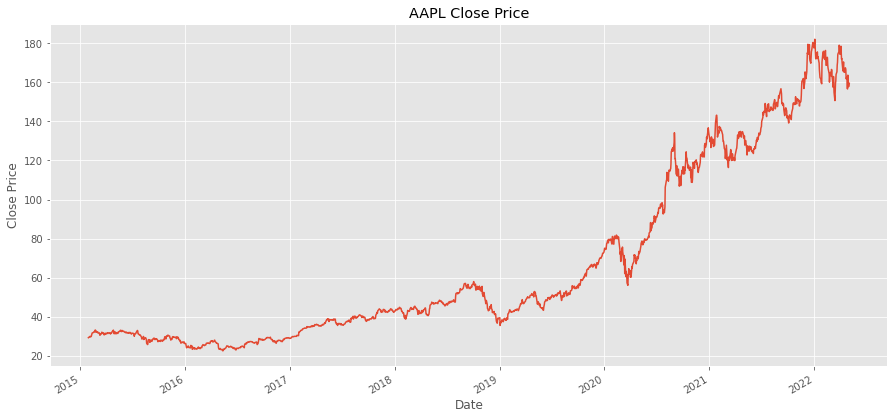

In [3]:
MyPort.plot()

Shorter EMA span (in no. of days)?: 12
Longer EMA span (in no. of days)?: 26
MACD span (in no. of days)?: 9


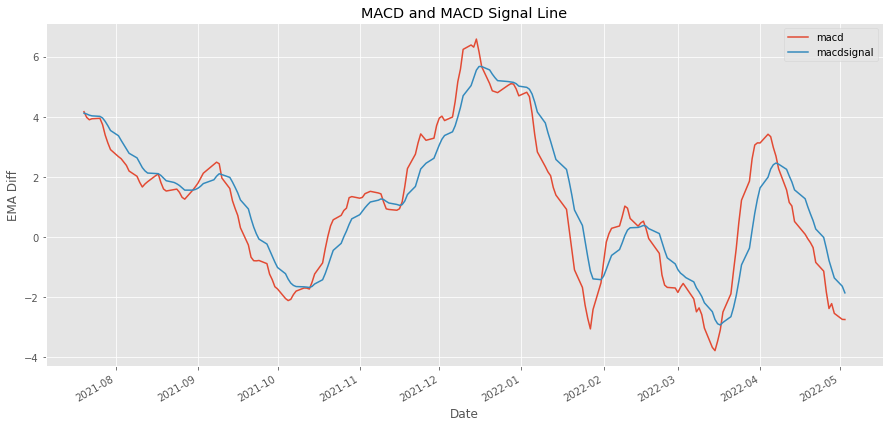

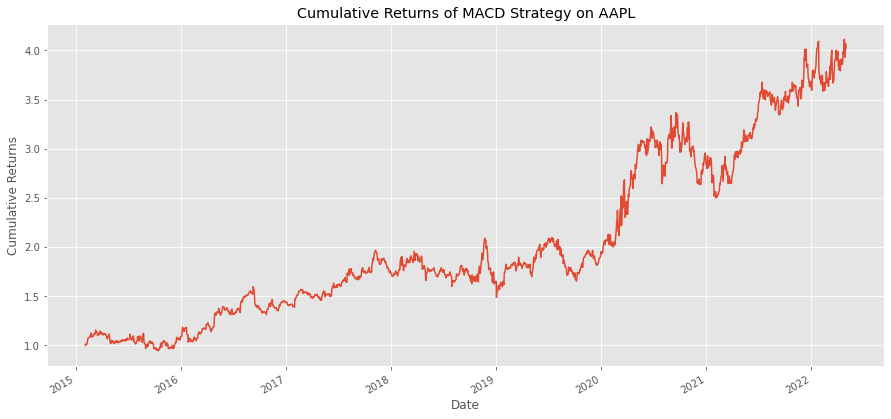

The CAGR is 21.16%
The annualised volatility is 29.04%
The Sharpe ratio is 0.74


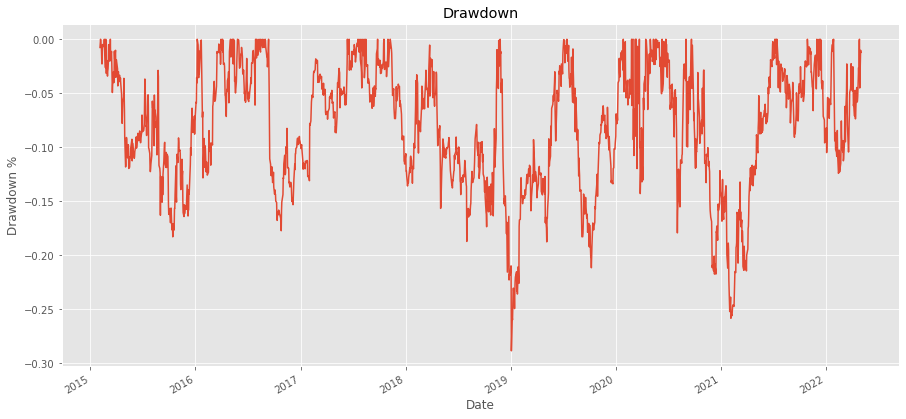

In [4]:
MyPort.ApplyMACD()